# The code in this notebook is adopted from the example at this link: https://towardsdatascience.com/from-theory-to-practice-with-bayesian-neural-network-using-python-9262b611b825

This notebook code can be found at our GitHub link: https://github.com/jhuan35/stat-431-final-project-bnn/blob/master/simple_bnn_example.ipynb

In [32]:
import pandas as pd
import numpy as np
from sklearn import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import matplotlib.pyplot as plt

# Let's generate some simple fake data

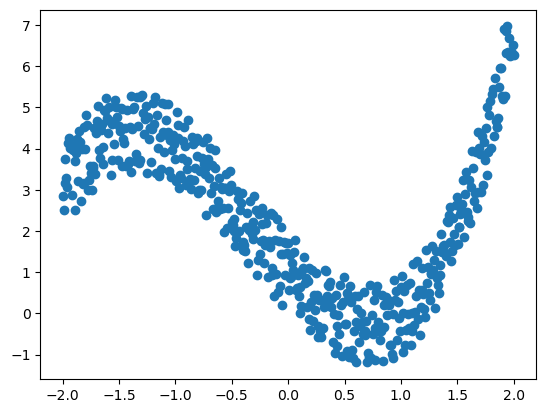

In [33]:
x = torch.linspace(-2, 2, 500)
# y = x^3 + x^2 - 3x + random error, where random error is uniform on [0, 2]
y = x.pow(3) + x.pow(2) - 3 * x.pow(1) + 2*torch.rand(x.size())
x = torch.unsqueeze(x, dim=1)
y = torch.unsqueeze(y, dim=1)

plt.scatter(x.data.numpy(), y.data.numpy())
plt.show()

# Let's define a simple 2-layer BNN. We are using a vague prior with mean zero and sigma = 0.1. We choose ReLU as our activation function.

In [34]:
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1, out_features=1000),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1000, out_features=1),
)

# Here we will use a balance of MSE loss and the Kullback-Leibler divergence for optimization:

In [35]:
mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01)

In [36]:
# training procedure
for step in range(2000):
    pre = model(x)
    mse = mse_loss(pre, y)
    kl = kl_loss(model)
    cost = mse + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

# Create our test set

In [37]:
# The true y value for a given x value. We add a 1 to the function we had above, since the mean of the uniform error is 1.
def true_y_value(x):
    return x.pow(3) + x.pow(2) - 3 * x.pow(1) + 1

# Generate the random y values for given x values.
def generate_y(x):
    return x.pow(3) + x.pow(2) - 3 * x.pow(1) + 2*torch.rand(x.size())

In [38]:
x_test = torch.linspace(-2, 2, 300)
y_test = generate_y(x_test)

x_test = torch.unsqueeze(x_test, dim=1)
y_test = torch.unsqueeze(y_test, dim=1)

# Look at the mean and standard deviation of the BNN's predictions at each x value

In [39]:
models_result = np.array([model(x_test).data.numpy() for k in range(10000)])
models_result = models_result[:,:,0]    
models_result = models_result.T
mean_values = np.array([models_result[i].mean() for i in range(len(models_result))])
std_values = np.array([models_result[i].std() for i in range(len(models_result))])

Text(0, 0.5, 'y')

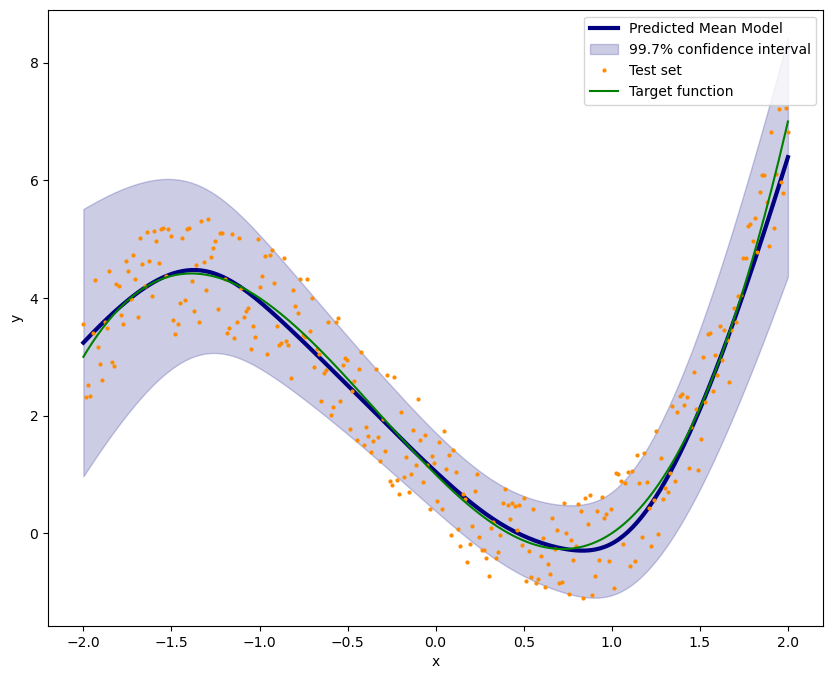

In [40]:
plt.figure(figsize=(10,8))
plt.plot(x_test.data.numpy(),mean_values,color='navy',lw=3,label='Predicted Mean Model')

plt.fill_between(x_test.data.numpy().T[0],mean_values-3.0*std_values,mean_values+3.0*std_values,alpha=0.2,color='navy',label='99.7% confidence interval')

plt.plot(x_test.data.numpy(),y_test.data.numpy(),'.',color='darkorange',markersize=4,label='Test set')
plt.plot(x_test.data.numpy(),true_y_value(x_test).data.numpy(),color='green',markersize=4,label='Target function')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')